In [1]:
# rain-sensor data pre-preparation 

import os
import csv
import numpy
import numpy as np

# define pre-variables
directory_path = "Regenereignisse/regendaten-main-Regen/Regen"
directory_path_hazard = "Gefahrenklassen/regendaten-main-Gefahrenklassen/Gefahrenklassen"
stored_rain_data = []
zeros_row = [0.0] * 25
count_file = 0
rain_files = os.listdir(directory_path)
collected_rain_files = [file for file in rain_files if file.endswith(".regen")]
sorted_regen_files = sorted(collected_rain_files, key=lambda x: int(x.split('.')[0]))
# iterate for rain-file through dircetory
for data_file_name in sorted_regen_files:
    data_file_path = os.path.join(directory_path, data_file_name)
    sensor_events = []
    # open rain file
    count = 0
    with open(data_file_path, "r", encoding="utf-8") as file:
        if count_file < 16:
            count +=1
            for row_number, row in enumerate(file, start=1):
                if len(row) == 80:
                    row_short = row[:60]
                    sensor_events.extend([float(value) for value in row_short.split()])
                    sensor_events.extend(zeros_row)
                    stored_rain_data.append(sensor_events)
                    sensor_events = []
            #print(file)
        else:
            # iterate through row and store data (if conditions are complied
            for row_number, row in enumerate(file, start=1):

                if len(row) == 60:
                    sensor_events.extend([float(value) for value in row.split()])
                    # fill sensor data with zeros to align model input and output
                    sensor_events.extend(zeros_row)
                    
                    stored_rain_data.append(sensor_events)
                    sensor_events = []
        count_file += 1
numpy_stored_rain_data = np.array(stored_rain_data)
print(numpy_stored_rain_data)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.07 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.29 ... 0.   0.   0.  ]
 [2.22 4.79 5.   ... 0.   0.   0.  ]]


In [2]:
# hazard-class data pre-preparation

class_folders = [str(i) for i in range(1,1897)]
# hazard-class data pre-preparation
hazard_class_collection = []
# iterates all subfolders
for subfolder in sorted(class_folders, key=int):
    hazard_subfolder = os.path.join(directory_path_hazard, subfolder)
    # iterates all files in subfolder
    for hazard_filename in os.listdir(hazard_subfolder):
        hazard_filename = os.path.join(hazard_subfolder, hazard_filename)
        # open csv-files - next(file) --> skip first row
        with open(hazard_filename, 'r', newline='', encoding='utf-8') as hazard_file:
            csv_reader = csv.reader(hazard_file)
            next(csv_reader)
            # read row (begin: second entry in row) - values separated by comma
            for excel_row in csv_reader:
                hazard_class_array = []
                for hazard_element in excel_row[1:]:
                    hazard_class_array.append(float(hazard_element))
                # store data in collection (arrays in array)
                hazard_class_collection.append(hazard_class_array)
numpy_hazard_output = np.array(hazard_class_collection)
print(numpy_hazard_output)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [80]:
# create train- and test-datasets for subsequent neural network model training and testing

# reshaping the arrays into formatting useable for prediction model
X = numpy_stored_rain_data.reshape(1896, 37, 8)
Y = numpy_hazard_output.reshape(1896, 37, 216)

# define train-dataset
train_data_rain = X[0:1264]
test_data_rain = X[1264:]

# define test-dataset
train_data_classification = Y[0:1264]
test_data_classification = Y[1264:]

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 37, 1896)          14447520  
_________________________________________________________________
dense_53 (Dense)             (None, 37, 216)           409752    
Total params: 14,857,272
Trainable params: 14,857,272
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
40/40 [==============================] - 25s 634ms/step - loss: 0.1379
Epoch 2/200
40/40 [==============================] - 25s 630ms/step - loss: 0.1359
Epoch 3/200
40/40 [==============================] - 25s 636ms/step - loss: 0.1365
Epoch 4/200
40/40 [==============================] - 25s 635ms/step - loss: 0.1410
Epoch 5/200
40/40 [==============================] - 25s 628ms/step - loss: 0.1363
Epoch 6/200
40/40 [==============================] - 25s 633ms/step - loss: 0.1347
Epoch

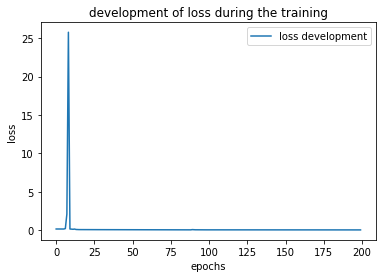

In [81]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
%matplotlib inline

# forecast model --> LSTM architecture withpout batch-sizing - 1896 input neurons - LSTM activation = relu - epochs = 250

model_no_batch_size = Sequential()
model_no_batch_size.add(LSTM(1896, return_sequences=True, input_shape=(37,8), activation='relu'))
model_no_batch_size.add(Dense(216, activation='relu'))
model_no_batch_size.compile(optimizer='adam', loss='MSE')
# print model shape
model_no_batch_size.summary()

# train model (without batch-sizes)
history = model_no_batch_size.fit(train_data_rain, train_data_classification, epochs=200)

#supervision of loss values - and graphical visualization
loss_values = history.history["loss"]
plt.plot(loss_values, label="loss development")
plt.title("development of loss during the training")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 37, 1896)          14447520  
_________________________________________________________________
lstm_47 (LSTM)               (None, 37, 512)           4933632   
_________________________________________________________________
dense_58 (Dense)             (None, 37, 500)           256500    
_________________________________________________________________
dense_59 (Dense)             (None, 37, 216)           108216    
Total params: 19,745,868
Trainable params: 19,745,868
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
40/40 [==============================] - 35s 874ms/step - loss: 0.1364
Epoch 2/200
40/40 [==============================] - 35s 871ms/step - loss: 0.1276
Epoch 3/200
40/40 [==============================] - 35s 873ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40/40 [==============================] - 36s 909ms/step - loss: 0.0158
Epoch 152/200
40/40 [==============================] - 37s 913ms/step - loss: 0.0152
Epoch 153/200
40/40 [==============================] - 36s 911ms/step - loss: 0.0149
Epoch 154/200
40/40 [==============================] - 36s 912ms/step - loss: 0.0143
Epoch 155/200
40/40 [==============================] - 36s 902ms/step - loss: 0.0141
Epoch 156/200
40/40 [==============================] - 36s 910ms/step - loss: 0.0139
Epoch 157/200
40/40 [==============================] - 37s 913ms/step - loss: 0.0138
Epoch 158/200
40/40 [==============================] - 36s 909ms/step - loss: 0.0136
Epoch 159/200
40/40 [==============================] - 36s 910ms/step - loss: 0.0132
Epoch 160/200
40/40 [==============================] - 37s 914ms/step - loss: 0.0130
Epoch 161/200
40/40 [==============================] - 36s 907ms/step - loss: 0.0128
Epoch 162/200
40/40 [==============================] - 36s 909ms/step - loss: 0

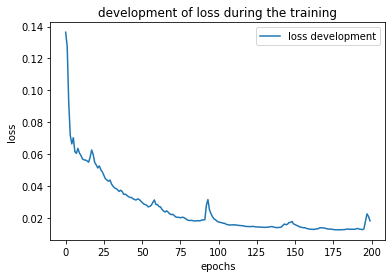

In [84]:
# addition of more layers - and batch sizing - 200 epochs
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
%matplotlib inline

# forecast model --> LSTM architecture with batch-sizing - LSTM activation = softmax - multilayer (2 LSTM, 2 Dense)

model_multilayer_batch_size = Sequential()
model_multilayer_batch_size.add(LSTM(1896, return_sequences=True, input_shape=(37, 8)))
model_multilayer_batch_size.add(LSTM(512, return_sequences=True))
model_multilayer_batch_size.add(Dense(500, activation='relu'))
model_multilayer_batch_size.add(Dense(216, activation='relu'))
model_multilayer_batch_size.compile(optimizer='adam', loss='MSE')
# print model shape
model_multilayer_batch_size.summary()

# train model (without batch-sizes)
history = model_multilayer_batch_size.fit(train_data_rain, train_data_classification, batch_size=32, epochs=200)

#supervision of loss values - and graphical visualization
loss_values = history.history["loss"]
plt.plot(loss_values, label="loss development")
plt.title("development of loss during the training")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 37, 8)             544       
_________________________________________________________________
dense_56 (Dense)             (None, 37, 1000)          9000      
_________________________________________________________________
dense_57 (Dense)             (None, 37, 216)           216216    
Total params: 225,760
Trainable params: 225,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 1s 25ms/step - loss: 0.1386
Epoch 2/100
40/40 [==============================] - 1s 24ms/step - loss: 0.1372
Epoch 3/100
40/40 [==============================] - 1s 23ms/step - loss: 0.1364
Epoch 4/100
40/40 [==============================] - 1s 23ms/step - loss: 0.1351
Epoch 5/100
40/40 [==============================] - 

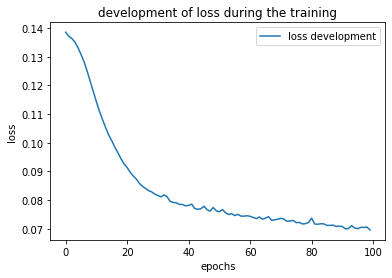

In [83]:
# addition of  layers - and batch sizing - 100 epochs - reduced input nodes
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
%matplotlib inline

# forecast model --> LSTM architecture with batch-sizing - LSTM activation = softmax - multilayer (2 LSTM, 2 Dense)
#reduced input nodes

model_multilayer = Sequential()
model_multilayer.add(LSTM(8, return_sequences=True, input_shape=(37, 8)))
model_multilayer.add(Dense(1000, activation='relu'))
model_multilayer.add(Dense(216, activation='relu'))
model_multilayer.compile(optimizer='adam', loss='MSE')
# print model shape
model_multilayer.summary()

# train model (batch-size=32)
history = model_multilayer.fit(train_data_rain, train_data_classification, batch_size=32, epochs=100)

#supervision of loss values - and graphical visualization
loss_values = history.history["loss"]
plt.plot(loss_values, label="loss development")
plt.title("development of loss during the training")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [85]:
# manual model prediction and safe models as .keras

# model prediction (test data)
predict_no_batch_size = model_no_batch_size.predict(test_data_rain)
predict_batch_multi = model_multilayer_batch_size.predict(test_data_rain)
predict_multilayer = model_multilayer.predict(test_data_rain)


# safe models
model_no_batch_size.save('no_batch_size_2_layer_model.keras')
model_multilayer_batch_size.save('batch_size_multilayer_model.keras')
model_multilayer.save('multilayer_model.keras')

In [86]:
# conversion of output shape

predict_no_batch_size = predict_no_batch_size.reshape(632, 216, 37)
predict_batch_multi = predict_batch_multi.reshape(632, 216, 37)
predict_multilayer = predict_multilayer.reshape(632, 216, 37)
test_data_classification = test_data_classification.reshape(632, 216, 37)

In [87]:
# manual model evaluation --> overall/ total model evaluation

def rounding_number(number):
    rounded_number = round(number)
    if (number >= rounded_number + 0.5) and number < 3:
        rounded_number += 1
    elif number > 3:
        rounded_number = 3
    return rounded_number

def evaluate_model(predicted_data):
    counting_equality = 0
    array_shape = predicted_data.shape
    for i in range(array_shape[0]):
        for j in range(array_shape[2]):
            for k in range(array_shape[1]):
                rounded_array_element = rounding_number(predicted_data[i, k, j])
                if rounded_array_element == test_data_classification[i, k, j]:
                    counting_equality += 1
    equality_percentage = (counting_equality / (632*37*216)) *100
    return equality_percentage

# calculate accuracy
result_no_batch_size = evaluate_model(predict_no_batch_size)
result_multilayer_batch_size = evaluate_model(predict_batch_multi)
print("result no_batch_size_2_layer_model: " + str(result_no_batch_size) + " % accuracy")
print("result multilayer_batch_size_model: " + str(result_multilayer_batch_size) + " % accuracy")
result_multilayer = evaluate_model(predict_multilayer)
print("result multilayer_reduced input nodes: " + str(result_multilayer) + " % accuracy")

result no_batch_size_2_layer_model: 98.04482092852346 % accuracy
result multilayer_batch_size_model: 98.08863452059654 % accuracy
result multilayer_reduced input nodes: 97.44208211375933 % accuracy


In [88]:
# manual model evaluation --> all numbers unequal (!=) 0.0

# function for rounding numbers --> up- and down-rounding according to the nature of input number (< or > (number + 0.5)
def rounding_number(number):
    rounded_number = round(number)
    if (number >= rounded_number + 0.5) and number < 3:
        rounded_number += 1
    elif number > 3:
        rounded_number = 3
    return rounded_number

# function counts and passes total amount of non-zero value fields in test_data_classification numpy array
def count_non_zero_values(test_data_set):
    counting_non_zero_fields = 0
    array_shape = test_data_set.shape
    for i in range(array_shape[0]):
        for j in range(array_shape[2]):
            for k in range(array_shape[1]):
                if test_data_set[i, k, j] != 0:
                    counting_non_zero_fields += 1
    return counting_non_zero_fields

# function evaluate accuracy of non-zero fields --> predicted-data / test-data
def evaluate_model_without_zeros(predicted_data):
    counting_equality = 0
    array_shape = predicted_data.shape
    for i in range(array_shape[0]):
        for j in range(array_shape[2]):
            for k in range(array_shape[1]):
                rounded_array_element = rounding_number(predicted_data[i, k, j])
                if rounded_array_element != 0 and rounded_array_element == test_data_classification[i, k, j]:
                    counting_equality += 1
                elif rounded_array_element
    total_amount_non_zero = count_non_zero_values(test_data_classification)
    equality_percentage = (counting_equality / total_amount_non_zero) *100
    return equality_percentage

# calculate accuracy
result_no_batch_size = evaluate_model_without_zeros(predict_no_batch_size)
result_multilayer_batch_size = evaluate_model_without_zeros(predict_batch_multi)
print("result no_batch_size_2_layer_model: " + str(result_no_batch_size) + " % accuracy for non-zero fields")
print("result multilayer_batch_size_model: " + str(result_multilayer_batch_size) + " % accuracy for non-zero fields")
result_multilayer = evaluate_model_without_zeros(predict_multilayer)
print("result multilayer_reduced input nodes: " + str(result_multilayer) + " % accuracy for non-zero fields")

result no_batch_size_2_layer_model: 42.40578533170911 % accuracy for non-zero fields
result multilayer_batch_size_model: 42.19502291316202 % accuracy for non-zero fields
result multilayer_reduced input nodes: 15.143956532668174 % accuracy for non-zero fields
